# Sensitivity to hue (HSV) of deep networks

In [2]:
import sys,os,warnings
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
from matplotlib import cm
import matplotlib as mpl
import pickle
import pandas as pd
from torchvision import models, transforms, utils
import colorsys
from colorspacious import cspace_convert
import seaborn as sns

%matplotlib inline

sys.path.insert(0, "..")

/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if 'COLAB_GPU' in os.environ:
    print("Running on Google Colab, setting up environment")
    !mkdir -p /content/scripts  # Create the 'scripts' folder if it doesn't exist
    !mkdir -p /content/figures  # Create the 'figures' folder if it doesn't exist
    !mkdir -p /content/data  # Create the 'data' folder if it doesn't exist

    !wget -P /content/scripts https://raw.githubusercontent.com/KordingLab/ANN_psychophysics/master/scripts/fisher_calculators.py

else:
    print("Not running on Google Colab, using local files")
    # Check if the folder exists
    figure_path = '../figures'
    data_path = '../data'

    if not os.path.isdir(figure_path):
        os.makedirs(figure_path)
    
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
cuda = torch.cuda.is_available()

if cuda:
    device = 'cuda'
if not cuda: 
    warnings.warn(f'CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab')
    device = 'cpu'

from scripts.fisher_calculators import get_fisher_orientations, get_fisher_hues


Not running on Google Colab, using local files


/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_16935/371853410.py:26: UserWarning: CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab
  warnings.warn(f'CUDA is not available. Notebook will be run on CPU, which will be !! 🐢 Very Slow 🐢 !! Consider running on Google Colab')


In [4]:
# Format plots 

plt.style.use('seaborn-white', )
plt.rcParams['axes.labelsize'] =  25
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0

/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_16935/2664462224.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white', )


In [5]:
def generator_hsv(hue):
    "in deg"
    
    c = colorsys.hsv_to_rgb(hue/360., 1., .8)

    arr = np.ones((224,224,3)) * c
    
    return torch.from_numpy(arr).permute(2,0,1).to(torch.float)

In [6]:
def generator_hsv_marginalized(hue):
    "in deg"
    
    c = np.array([[colorsys.hsv_to_rgb(hue/360., s, v) 
                       for s in np.linspace(.5,.9, 8)]
                          for v in np.linspace(.5,.9, 8)])
#     print(c.shape)
    arr = c.reshape(64,3,1,1)*np.ones((3,224,224))
    
    return torch.from_numpy(arr).to(torch.float)

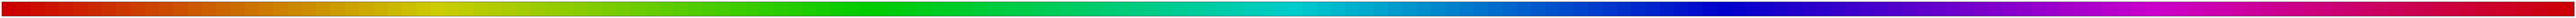

In [7]:
sns.palplot([(generator_hsv(hue)[:,0,0]).numpy() for hue in range(0,360,2)])

In [8]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().set_visible(False)
    ax.xaxis.set_tick_params(size=6)
#     ax.yaxis.set_tick_params(size=6)

In [9]:
def get_fisher(model, title, N=10, n_colors=360, scale=None, savefig=None,generator=generator_hsv_marginalized ):

    fishers = []
    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_hues(model,i,n_colors, delta=.1,
                                                                  generator=generator)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        fishers.append(normed)
    return fishers


In [10]:
def plot_fisher(model, title, N=10, n_colors=360, scale=None, savefig=None,generator=generator_hsv_marginalized ):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))

    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_hues(model,i,n_colors, delta=.1,
                                                                  generator=generator)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        plt.plot(np.linspace(0, 360, n_colors),normed,"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(normed),2*np.mean(normed)))
    plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.xlabel("Hue (º)", fontsize = 15)

    plt.xticks(np.linspace(0,360,5))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)

    plt.title(title, fontsize=20)
    clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

In [1]:
def plot_fisher_spectral(model, title, N=10, scale=None, savefig=None,):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))
    r= range(450,650,5)
    for i in tqdm(range(N)):
        sqrt_fishers_resnet = np.sqrt(torch.stack(get_fisher_hues(model,i, delta=.1, hues = r,
                                                                  generator=generator_spectral)).cpu().numpy())
        normed =  sqrt_fishers_resnet/np.sum(sqrt_fishers_resnet)
        plt.plot(r,normed,"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(normed),2*np.mean(normed)))
    plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.xlabel("Approx. wavelength (nm)", fontsize = 15)

    plt.xticks(range(450,651,50))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)

    plt.title(title, fontsize=20)
    clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

## Get distance in CIELAB space

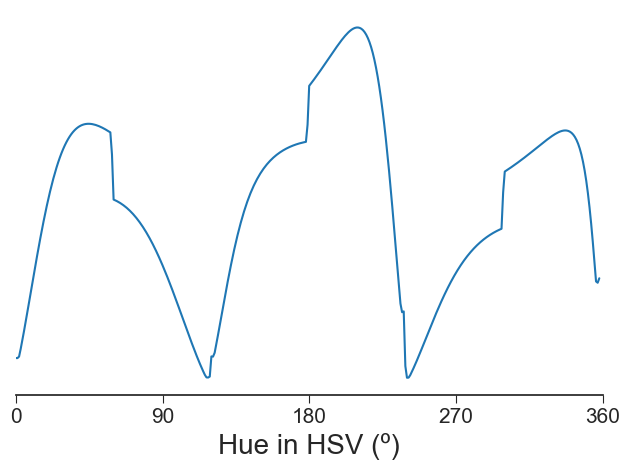

In [11]:
# get array of hsv 
colors = np.ones((360,3))
colors[:,0]=np.linspace(0,1,360)
colors[:,2]=1
# pass to rgb
colors_rgb = [colorsys.hsv_to_rgb(*c) for c in colors]

# then cielab
colors = cspace_convert(colors_rgb, "sRGB1", "CIELab")
#get diff
diff = []
for i in range(1,len(colors)):
    diff.append(np.linalg.norm(colors[i-1]-colors[i]))
plt.plot(diff)
plt.ylabel("Perceptual distance", fontsize = 20)
plt.xlabel("Hue in HSV (º)", fontsize = 20)

plt.xticks(np.linspace(0,360,5))
plt.yticks([])

#     plt.title("Layer {}".format(i), fontsize=15)
#     plt.show()
simpleaxis(plt.gca())


plt.xlim([0,360])
# plt.title(title, fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(figure_path,'CIELAB_hue.pdf'))
plt.show()

# Resnet

In [12]:
model = models.resnet18(pretrained=True).to(device).eval()
fishers = get_fisher(model, "Resnet18", 10, generator=generator_hsv,
            n_colors=360)

/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/melian/miniconda3/envs/ANNPsych/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


In [14]:

def plot_precomputed_fishers(fishers, title, N=10, n_colors=360, scale=None, savefig=None,generator=generator_hsv_marginalized ):
    cs = sns.color_palette('plasma', N)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cs, len(cs))

    for i in tqdm(range(N)):
        
        plt.plot(np.linspace(0, 360, n_colors),fishers[i],"-", label = "Layer {}".format(i+1),c=cs[i])
    plt.ylim(bottom=0, top = max(max(fishers[i]),2*np.mean(fishers[i])))
    plt.ylabel(r"$\sqrt{J(\theta)}$ (normalized)", fontsize = 15)
    plt.xlabel("Hue (º)", fontsize = 15)

    plt.xticks(np.linspace(0,360,5))
    #     plt.title("Layer {}".format(i), fontsize=15)
    #     plt.show()

    if scale is not None:
        plt.ylim(scale)
    simpleaxis(plt.gca())
    plt.xlim([0,360])
    plt.title(title, fontsize=20)
    clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))
    clb.ax.set_title('Layer')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

100%|██████████| 10/10 [00:00<00:00, 701.32it/s]
/var/folders/bz/3y6h4p4n3j7599px3yrpt06h0000gn/T/ipykernel_16935/3560187276.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  clb = plt.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=N), cmap=cmap))


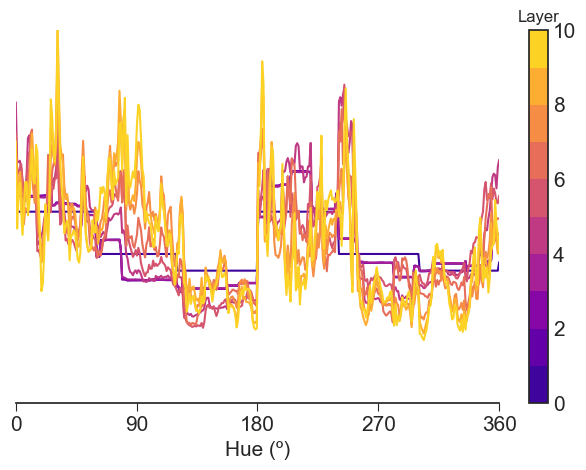

In [15]:
plot_precomputed_fishers(fishers, None, 10, generator=generator_hsv,
            n_colors=360, savefig=None)

## On rotated hue. 

Requires retraining a network. Look to training script at `train_rotated.py`.

In [ ]:
#path = '/data/abenjamin/DNN_illusions/resnet18_rotated_hue/checkpoint_epoch_{}.pth.tar'.format(90)
#checkpoint = torch.load(path)
#model.load_state_dict(checkpoint['state_dict'])
#rotated_fishers = get_fisher(model, "Resnet18", 10, generator=generator_hsv_marginalized,
#                        n_colors=360)


In [ ]:
#plot_precomputed_fishers(rotated_fishers, "Resnet18", 10, generator=generator_hsv_marginalized,
#                        n_colors=360, savefig="figures/resnet18_hue_rotated_marginalized.pdf")